In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from copy import deepcopy as dc

from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go



In [ ]:
files = ['./data/2004.csv', './data/2005.csv', './data/2006.csv','./data/2007.csv', './data/2008.csv', './data/2009.csv','./data/2010.csv', './data/2011.csv', './data/2012.csv','./data/2013.csv', './data/2014.csv', './data/2015.csv','./data/2016.csv', './data/2017.csv', './data/2018.csv','./data/2019.csv', './data/2020.csv', './data/2021.csv','./data/2022.csv', './data/2023.csv', './data/2024.csv']  

# data = pd.read_csv(files[10])

# data

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).to(device),
                            torch.zeros(1,1,self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
for file in files[:-1]:  # Exclude the current year's data for training
    # Load and preprocess data
    data = pd.read_csv(file)
    data['Date'] = pd.to_datetime(data['Date'])
    data = data[['Date', 'Price']]

    # Prepare the data for training
    data['Price'] = data['Price'].astype(float)
    data = data.set_index('Date')
    price = data['Price'].values

    # Create sequences for training
    def create_sequences(data, seq_length):
        xs = []
        ys = []
        for i in range(len(data)-seq_length):
            x = data[i:i+seq_length]
            y = data[i+seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    seq_length = 12  # Example sequence length
    X, y = create_sequences(price, seq_length)

    X = torch.from_numpy(X).float().to(device)
    y = torch.from_numpy(y).float().to(device)

    # Define the model, loss function, and optimizer
    model = LSTM(input_size=1, hidden_layer_size=50, output_size=1).to(device)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    model.train()
    epochs = 100
    for epoch in range(epochs):
        for seq, labels in zip(X, y):
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                                 torch.zeros(1, 1, model.hidden_layer_size).to(device))
            y_pred = model(seq)
            labels = labels.view(1)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch} loss: {single_loss.item()}')

    # Save the trained model
    torch.save(model.state_dict(), f'lstm_model_{file.split("/")[-1].split(".")[0]}.pt')

Epoch 0 loss: 42.92265701293945
Epoch 10 loss: 27.470151901245117
Epoch 20 loss: 33.9599494934082
Epoch 30 loss: 8.58588981628418
Epoch 40 loss: 0.967985212802887
Epoch 50 loss: 0.003004925325512886
Epoch 60 loss: 0.002010912401601672
Epoch 70 loss: 0.0684051364660263
Epoch 80 loss: 0.07663442939519882
Epoch 0 loss: 0.16097918152809143
Epoch 10 loss: 3.947120189666748
Epoch 20 loss: 2.745854616165161
Epoch 30 loss: 1.5930252075195312
Epoch 40 loss: 0.8605406880378723
Epoch 50 loss: 0.42862433195114136
Epoch 60 loss: 0.282835990190506
Epoch 70 loss: 0.4882335066795349
Epoch 80 loss: 0.013131917454302311
Epoch 0 loss: 24.967737197875977
Epoch 10 loss: 1.503723382949829
Epoch 20 loss: 1.1424587965011597
Epoch 30 loss: 0.5737053751945496
Epoch 40 loss: 0.2955622375011444
Epoch 50 loss: 0.13253581523895264
Epoch 60 loss: 0.10010235756635666
Epoch 70 loss: 0.03705427423119545
Epoch 80 loss: 0.020990299060940742
Epoch 0 loss: 131.55596923828125
Epoch 10 loss: 182.09695434570312
Epoch 20 loss:

/tmp/ipykernel_38971/3331261922.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


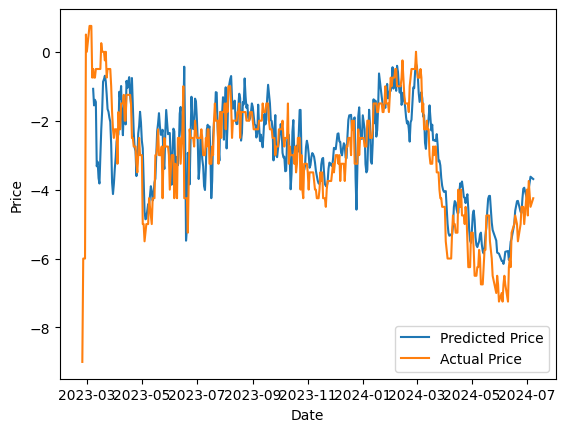

In [ ]:
current_year_file = files[-1]
data = pd.read_csv(current_year_file)
data['Date'] = pd.to_datetime(data['Date'])
data = data[['Date', 'Price']]

# Prepare the data for prediction
data['Price'] = data['Price'].astype(float)
data = data.set_index('Date')
price = data['Price'].values

# Use the most recent model for prediction
model_file = 'lstm_model_2023.pt'
model = LSTM(input_size=1, hidden_layer_size=50, output_size=1).to(device)
model.load_state_dict(torch.load(model_file))
model.eval()

# Create sequences for prediction
X, y = create_sequences(price, seq_length)

X = torch.from_numpy(X).float().to(device)

# Make predictions
predictions = []
for seq in X:
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                             torch.zeros(1, 1, model.hidden_layer_size).to(device))
        predictions.append(model(seq).item())

# Plot the predictions
plt.plot(data.index[seq_length:], predictions, label='Predicted Price')
plt.plot(data.index, price, label='Actual Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

/tmp/ipykernel_38971/4058768038.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


ValueError: x and y must have same first dimension, but have shapes (472,) and (482,)

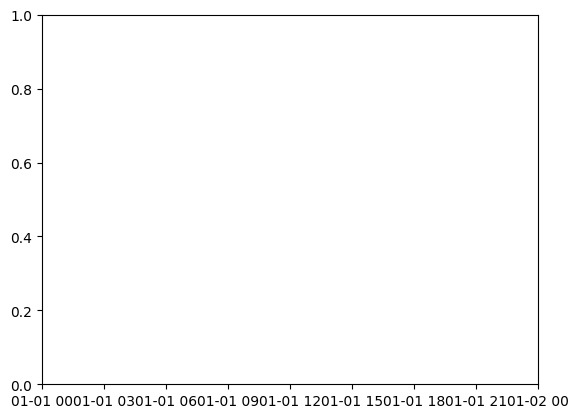

In [ ]:
current_year_file = files[-1]
data = pd.read_csv(current_year_file)
data['Date'] = pd.to_datetime(data['Date'])
data = data[['Date', 'Price']]

# Prepare the data for prediction
data['Price'] = data['Price'].astype(float)
data = data.set_index('Date')
price = data['Price'].values

# Use the most recent model for prediction
model_file = 'lstm_model_2023.pt'
model = LSTM(input_size=1, hidden_layer_size=50, output_size=1).to(device)
model.load_state_dict(torch.load(model_file))
model.eval()

# Create sequences for prediction
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12  # Example sequence length

# Create sequences for prediction
X, y = create_sequences(price, seq_length)

X = torch.from_numpy(X).float().to(device)

# Make predictions
predictions = []
for seq in X:
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                             torch.zeros(1, 1, model.hidden_layer_size).to(device))
        predictions.append(model(seq).item())

# Predict the next 7-10 days
pred_days = 10
last_seq = X[-1].cpu().numpy()

for _ in range(pred_days):
    seq = torch.from_numpy(last_seq).float().to(device)
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                             torch.zeros(1, 1, model.hidden_layer_size).to(device))
        pred = model(seq).item()
        predictions.append(pred)
        last_seq = np.append(last_seq[1:], pred)

# Plot the predictions
all_dates = np.append(data.index[seq_length:], pd.date_range(start=data.index[-1], periods=pred_days + 1, inclusive='right')[1:])


# Plot the predictions
# plt.plot(all_dates, predictions, label='Predicted Price')
# plt.plot(data.index, price, label='Actual Price')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.show()

# Create a Plotly figure
fig = go.Figure()

# Add actual price data to the figure
fig.add_trace(go.Scatter(x=data.index, y=price, mode='lines', name='Actual Price'))

# Add predicted price data to the figure
fig.add_trace(go.Scatter(x=all_dates, y=predictions, mode='lines', name='Predicted Price'))

# Update layout
fig.update_layout(
    title='Price Prediction',
    xaxis_title='Date',
    yaxis_title='Price'
)

# Show the figure
fig.show()